In [1]:
import numpy as np
import matplotlib.pyplot as plt

from modules.reward import BellamanFord_modified, create_graph, get_bonus_counts

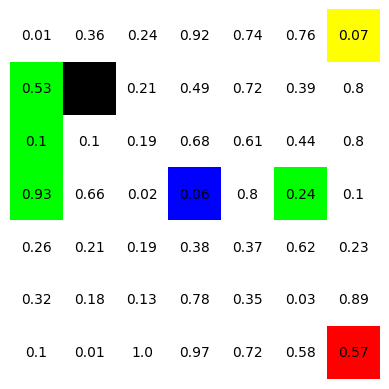

In [2]:
def paint_map(processed_state_i):
    stones_mask, preys_mask, enemies_mask, bonuses_mask, distance_mask = processed_state_i

    image = np.empty((*preys_mask.shape, 3), dtype=int)
    image.fill(255)
    image[stones_mask == 1] = 0, 0, 0
    image[preys_mask == 1] = 0, 255, 0
    image[enemies_mask == 1] = 255, 0, 0
    image[bonuses_mask == 1] = 255, 255, 0
    image[3, 3] = 0, 0, 255

    fig, ax = plt.subplots()
    im = ax.imshow(image)
    im.set_extent((0, distance_mask.shape[1], distance_mask.shape[0], 0))

    for i in range(distance_mask.shape[0]):
        for j in range(distance_mask.shape[1]):
            ax.text(j+0.5, i+0.5, str(distance_mask[i, j]), ha='center', va='center', fontsize=10)

    plt.axis("off")
    plt.show()

shape = (7, 7)

stones_mask = np.zeros(shape, dtype=np.float32)
stones_mask[1,1] = 1

preys_mask = np.zeros(shape, dtype=np.float32)
preys_mask[1, 0] = 1
preys_mask[2, 0] = 1
preys_mask[3, 0] = 1
preys_mask[3, 5] = 1

enemies_mask = np.zeros(shape, dtype=np.float32)
enemies_mask[6, 6] = 1

bonuses_mask = np.zeros(shape, dtype=np.float32)
bonuses_mask[0, 6] = 1
# 
distance_mask = np.round(np.random.rand(*shape), 2)
# distance_mask = np.round(get_distance_mask(stones_mask), 2)

processed_state = np.stack([stones_mask, preys_mask, enemies_mask, bonuses_mask, distance_mask])

paint_map(processed_state)

In [3]:
def get_state_value_new(reward_weights, processed_state, info, n_steps=10, src=(20, 20)):
    """Returns ndarray[N_PREDATORS] containing state value for each predator"""
    assert len(processed_state.shape) == 4, 'the shape must be: [N_PREDATORS, N_MASKS, MAP_SIZE, MAP_SIZE]'
    n_predators = processed_state.shape[0]
    bonus_counts = get_bonus_counts(info)

    out = []
    for i in range(n_predators):
        weights = reward_weights.copy()
        weights["w_kill_bonus"] = weights["w_kill_bonus"] * (0.5 ** bonus_counts[i])
        weights["w_kill_enemy"] = weights["w_kill_enemy"] if bonus_counts[i] > 0 else 0
        graph = create_graph(weights, processed_state[i, ...])

        bf_mask = BellamanFord_modified(graph, n_steps, reward_weights, source=src)
        state_value_bf = bf_mask.max()
        state_value_residual = get_residual_state_value(reward_weights, processed_state, bf_mask)
        state_value = state_value_bf + state_value_residual

        out.append(state_value)
    return np.array(out)


def get_reward_mask(processed_state, reward_weights):
    assert len(processed_state.shape) == 3, 'the shape must be: [N_MASKS, MAP_SIZE, MAP_SIZE]'
    stones_mask, preys_mask, enemies_mask, bonuses_mask, _ = processed_state
    reward_mask = np.zeros_like(stones_mask)
    reward_mask[preys_mask == 1] = reward_weights['w_kill_prey']
    reward_mask[enemies_mask == 1] = reward_weights['w_kill_enemy']
    reward_mask[bonuses_mask == 1] = reward_weights['w_kill_bonus'] 
    return reward_mask


def get_residual_state_value(reward_weights, processed_state, bf_mask):
    assert len(processed_state.shape) == 3, 'the shape must be: [N_MASKS, MAP_SIZE, MAP_SIZE]'
    *_, distance_mask = processed_state
    reward_mask = get_reward_mask(processed_state, reward_weights)
    weighted_reward_mask = reward_mask * (1 - distance_mask)    
    weighted_reward_mask[bf_mask == -np.inf] = 0
    return np.sum(weighted_reward_mask)

[-0.2   -0.275 -0.35  -0.425 -0.5  ]


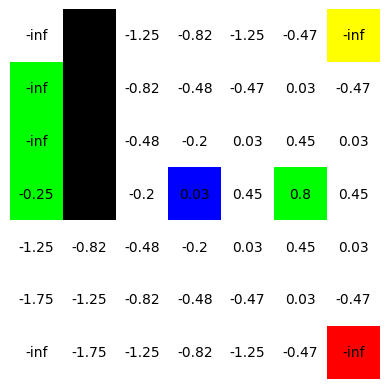

In [13]:
reward_params = dict(
    w_kill_prey=1.,
    w_kill_enemy=2.1,
    w_kill_bonus=1.3,
    gamma_for_bonus_count=0.5,
    w_dummy_step_start=-0.2,
    w_dummy_step_end=-0.5,
    split_step=5
)

graph = create_graph(reward_params, processed_state, can_pass_edges=False)
bf_mask = np.round(BellamanFord_modified(
    graph,
    reward_params=reward_params,
    shape=(7, 7),
    src=(3, 3),    
), 2)

stones_mask = np.zeros(shape, dtype=np.float32)
stones_mask[np.arange(4), 1] = 1
print(np.linspace(-0.2, -0.5, reward_params['split_step']))
processed_state = np.stack([stones_mask, preys_mask, enemies_mask, bonuses_mask, bf_mask])
paint_map(processed_state)